In [245]:
import nltk 
from nltk.corpus import brown
from nltk import bigrams, ngrams, trigrams 
from string import punctuation
import numpy as np
import matplotlib.pyplot as plt
import math


In [213]:
print("##########  ASSIGNMENT PART 1  ##############")

dataset = brown.sents()
print("Dataset loaded with %d no of sentences."%len(dataset))

##########  ASSIGNMENT PART 1  ##############
Dataset loaded with 57340 no of sentences.


In [214]:
dataProcessed = [ [word.lower() for word in sentence if word not in punctuation] for sentence in dataset ]
print("Data preprocessed with special characters removed.")

Data preprocessed with special characters removed.


In [215]:
train = dataProcessed[0:40000]
test = dataProcessed[40000:]
print("Train data : ",40000)

Train data :  40000


In [257]:
class LanguageModel():
    
    def __init__(self,sentences,n_gram,smoothing='none',laplace_constant=0.5,lambda1=0.5,lambda2=0.5,plotZipf=False):
        self.smoothing = smoothing
        self.modelDictionary={}
        self.laplace_constant=laplace_constant
        self.n_gram = n_gram
        self.plotZipf = plotZipf
        if n_gram == 1:
            self.unigramModel(sentences)
        elif n_gram == 2:
            self.bigramModel(sentences)
        elif n_gram == 3:
            self.trigramModel(sentences)
        
    def bigramModel(self,sentences):
                
        if self.smoothing == 'interpolation':
            self.ug = None
            self.bg = None
        
            self.ug = LanguageModel(sentences,1)
            self.bg = LanguageModel(sentences,2)
            
            return        
        
        model = {}
        maxim = 1
        for sent in sentences:
            for w1,w2 in ngrams(sent, 2, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                if w1 in model:
                    if w2 in model[w1]:
                        model[w1][w2] += 1
                        self.modelDictionary[(w1,w2)] += 1
                        value = self.modelDictionary[(w1,w2)]
                        if value > maxim:
                            maxim = value
                    else:
                        model[w1][w2] = 1
                        self.modelDictionary[(w1,w2)] = 1
                else:
                    model[w1] = {}
                    model[w1][w2] = 1
                    self.modelDictionary[(w1,w2)] = 1

        if self.plotZipf == True:
            values = sorted(list(self.modelDictionary.values()), reverse=True)
            self.xplot = range(len(values))
            self.yplot = [ math.log(values[i]) + math.log(i+1) for i in range(len(values))  ]
           
        un = len(self.modelDictionary)
        goodSmoothStore = np.ones(maxim + 2)
        gooddeno = 0
        
        if self.smoothing == 'goodturing':
            for value in self.modelDictionary.values():
                goodSmoothStore[value] += 1
                
            for index in range(len(goodSmoothStore)):
                gooddeno += (index)*goodSmoothStore[index]
            
            unique = {}
            for sent in sentences:
                for word in ngrams(sent,1):
                    unique[word] = 1
                    
            goodSmoothStore[0] = (len(unique)+2)**2 - un # +2 because of <s> and </s>

        for w1 in model:
            subcount = float(sum(model[w1].values()))
            
            for w2 in model[w1]:
                if self.smoothing == 'none':
                    model[w1][w2] /= subcount
                    self.modelDictionary[(w1,w2)] /= subcount
                elif self.smoothing == 'laplace':
                    model[w1][w2] += self.laplace_constant
                    model[w1][w2] /= (self.laplace_constant*un + subcount)
                    self.modelDictionary[(w1,w2)] += self.laplace_constant
                    self.modelDictionary[(w1,w2)] /= (self.laplace_constant*un + subcount)         
                elif self.smoothing == 'goodturing':
                    tempValue = model[w1][w2]
                    rstar = float(tempValue+1)*goodSmoothStore[tempValue+1]/goodSmoothStore[tempValue]
                    model[w1][w2] = rstar/float(gooddeno)
                    self.modelDictionary[(w1,w2)] = rstar/float(gooddeno)
           
            self.modelDictionary[(w1,'UKN')] = 0
            model[w1]['UKN'] = 0
            
            if self.smoothing == 'laplace':
                model[w1]['UKN'] = self.laplace_constant / (self.laplace_constant*un + subcount)
                self.modelDictionary[(w1,'UKN')] = self.laplace_constant / (self.laplace_constant*un + subcount)
            elif self.smoothing == 'goodturing':
                rstar = 1.0*goodSmoothStore[1]/float(goodSmoothStore[0])
                model[w1]['UKN'] = rstar/float(gooddeno)
                self.modelDictionary[(w1,'UKN')] = rstar/float(gooddeno)
            
        model['UKN'] = {}
        model['UKN']['UKN'] = 0
        self.modelDictionary[('UKN','UKN')] = 0

        if self.smoothing == 'laplace':            
            model['UKN']['UKN'] = 1.0 / un
            self.modelDictionary[('UKN','UKN')] = 1.0 / un
        elif self.smoothing == 'goodturing':
            rstar = 1.0*goodSmoothStore[1]/float(goodSmoothStore[0])
            model['UKN']['UKN'] = rstar/float(gooddeno)
            self.modelDictionary[('UKN','UKN')] = rstar/float(gooddeno)
            
            
    
    def unigramModel(self,sentences):
        count = 0
        for sent in sentences:
            for w in ngrams(sent,1,pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                count += 1
                if w in self.modelDictionary:
                    self.modelDictionary[w] += 1
                else:
                    self.modelDictionary[w] = 1

        if self.plotZipf == True:
            values = sorted(list(self.modelDictionary.values()), reverse=True)
            self.xplot = range(len(values))
            self.yplot = [ math.log(values[i]) + math.log(i+1) for i in range(len(values))  ]
            
        for w in self.modelDictionary:
            if self.smoothing == 'laplace':
                self.modelDictionary[w] += self.laplace_constant
                self.modelDictionary[w] /= (self.laplace_constant*count + count)
            else:
                self.modelDictionary[w] /= (count)
        if self.smoothing == 'laplace':
            self.modelDictionary[('UKN',)] = self.laplace_constant / (self.laplace_constant*count + count)
        else:
            self.modelDictionary[('UKN',)] = 0

    def trigramModel(self,sentences,lambda1=0.5,lambda2=0.5):
        model = {}
        maxim = 1
        
        if self.smoothing == 'interpolation':
            self.ug = None
            self.bg = None
            self.tg = None
        
            self.ug = LanguageModel(sentences,1)
            self.bg = LanguageModel(sentences,2)
            self.tg = LanguageModel(sentences,3)
            
            return
        
        for sent in sentences:
            for w1,w2,w3 in ngrams(sent, 3, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                if w1 in model:
                    
                    if w2 in model[w1]:
                       
                        if w3 in model[w1][w2]:
                            model[w1][w2][w3] += 1
                            self.modelDictionary[(w1,w2,w3)] += 1
                            value = self.modelDictionary[(w1,w2,w3)]
                            if value > maxim:
                                maxim = value
                            
                        else:
                            model[w1][w2][w3] = 1
                            self.modelDictionary[(w1,w2,w3)] = 1
                    else:
                        model[w1][w2] = {}
                        model[w1][w2][w3] = 1
                        self.modelDictionary[(w1,w2,w3)] = 1
                else:
                    model[w1] = {}
                    model[w1][w2] = {}
                    model[w1][w2][w3] = 1
                    self.modelDictionary[(w1,w2,w3)] = 1
        
        if self.plotZipf == True:
            values = sorted(list(self.modelDictionary.values()), reverse=True)
            self.xplot = range(len(values))
            self.yplot = [ math.log(values[i]) + math.log(i+1) for i in range(len(values))  ]
        
        un = len(self.modelDictionary)
        goodSmoothStore = np.ones(maxim + 2)
        gooddeno = 0
        
        if self.smoothing == 'goodturing':
            for value in self.modelDictionary.values():
                goodSmoothStore[value] += 1
                
            for index in range(len(goodSmoothStore)-1):
                gooddeno += (index)*goodSmoothStore[index]
            
            unique = {}
            for sent in sentences:
                for word in ngrams(sent,1):
                    unique[word] = 1
                    
            goodSmoothStore[0] = (len(unique)+2)**3 - un # +2 because of <s> and </s>
        
        
        for w1 in model:
            for w2 in model[w1]:
                subcount = float(sum(model[w1][w2].values()))
                
                for w3 in model[w1][w2]:
             
                    if self.smoothing == 'none':
                        model[w1][w2][w3] /= float(subcount)
                        self.modelDictionary[(w1,w2,w3)] /= float(subcount)
                    elif self.smoothing == 'laplace':
                        model[w1][w2][w3] += self.laplace_constant
                        model[w1][w2][w3] /= (self.laplace_constant*un + subcount)
                        self.modelDictionary[(w1,w2,w3)] += self.laplace_constant
                        self.modelDictionary[(w1,w2,w3)] /= (self.laplace_constant*un + subcount)
                    elif self.smoothing == 'goodturing':
                        tempValue = model[w1][w2][w3]
                        rstar = float(tempValue+1)*goodSmoothStore[tempValue+1]/goodSmoothStore[tempValue]
                        model[w1][w2][w3] = rstar/gooddeno
                    
                model[w1][w2]['UKN'] = 0
                self.modelDictionary[(w1,w2,'UKN')] = 0                        
                
                if self.smoothing == 'laplace':
                    model[w1][w2]['UKN'] = self.laplace_constant / (self.laplace_constant*un + subcount)
                    self.modelDictionary[(w1,w2,'UKN')] = self.laplace_constant / (self.laplace_constant*un + subcount)                                       
                elif self.smoothing == 'goodturing':
                    rstar = 1.0*goodSmoothStore[1]/goodSmoothStore[0]
                    model[w1][w2]['UKN'] = rstar/gooddeno
                    self.modelDictionary[(w1,w2,'UKN')] = rstar/gooddeno
               
            model[w1]['UKN'] = {}
            model[w1]['UKN']['UKN'] = 0
            self.modelDictionary[(w1,'UKN','UKN')] = 0
            
            if self.smoothing == 'laplace':
                model[w1]['UKN']['UKN'] = 1.0/un
                self.modelDictionary[(w1,'UKN','UKN')] = 1.0/un
            elif self.smoothing == 'goodturing':
                rstar = 1.0*goodSmoothStore[1]/goodSmoothStore[0]
                model[w1]['UKN']['UKN'] = rstar/gooddeno
                self.modelDictionary[(w1,'UKN','UKN')] = rstar/gooddeno
            
        model['UKN'] = {}
        model['UKN']['UKN'] = {}
        model['UKN']['UKN']['UKN'] = 0
        self.modelDictionary[('UKN','UKN','UKN')] = 0
    
        if self.smoothing == 'laplace':
            model['UKN']['UKN']['UKN'] = 1.0/un
            self.modelDictionary[('UKN','UKN','UKN')] = 1.0/un
        elif self.smoothing == 'goodturing':    
            rstar = 1.0*goodSmoothStore[1]/goodSmoothStore[0]
            model['UKN']['UKN']['UKN'] = rstar/gooddeno
            self.modelDictionary[('UKN','UKN','UKN')] = rstar/gooddeno

            
            
    def query(self,key):
        keyList = list(key)
        if self.smoothing == 'interpolation':
            if self.n_gram == 2:
                return lambda1*self.bg.query(key) + (1-lambda1)*self.ug.query((keyList[1],))
            elif self.n_gram == 3:
                return lambda2 *self.tg.query(key) + lambda1*self.bg.query((keyList[1],keyList[2])) + (1-lambda1 - lambda2)*self.ug.query((keyList[2],))
            elif self.n_gram == 1:
                return None
            
        if key not in self.modelDictionary:
            keyLen = len(keyList)
            keyList[keyLen-1] = 'UKN'
            if tuple(keyList) in self.modelDictionary:
                return self.modelDictionary[tuple(keyList)]
            else:
                keyList[keyLen-2] = 'UKN'
                return self.modelDictionary[tuple(keyList)]
        else:
            return self.modelDictionary[key]
    
    def keys(self):
        return self.modelDictionary.keys()
    
    def items(self):
        return self.modelDictionary.items()
    
    def values(self):
        return self.modelDictionary.values()
    
    def showPlot(self):
        plt.plot(self.xplot,self.yplot)
        plt.ylabel('log(frequency)+log(rank)')
        plt.xlabel('rank')
        
    
    def test(self,testcases,type='loglikelihood'):
        if type == 'loglikelihood':
            if self.n_gram == 1:
                unigramLLH1 = []
                for sent in testcases:
                    prob = 1
                    for word in ngrams(sent,1, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                        prob *= self.query(word)
                    if prob == 0:
                        unigramLLH1.append(-float('Inf'))
                    else:
                        unigramLLH1.append(math.log(prob))
                return unigramLLH1
            elif self.n_gram == 2:
                bigramLLH1 = []
                for sent in testcases:
                    prob = 1
                    for word in ngrams(sent, 2, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                        prob *= self.query(word)
                    if prob == 0:
                        bigramLLH1.append(-float('Inf'))
                    else:
                        bigramLLH1.append(math.log(prob)) 
                return bigramLLH1
            elif self.n_gram == 3:
                trigramLLH = []
                for sent in testcases:
                    prob = 1
                    for word in ngrams(sent, 3, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                        prob *= self.query(word)
                    if prob == 0:
                        trigramLLH.append(-float('Inf'))
                    else:
                        trigramLLH.append(math.log(prob))
                return trigramLLH
        elif type == 'perplexity':
            if self.n_gram == 1:
                unigramLLH = []
                for sent in testcases:
                    prob = 1
                    for word in ngrams(sent, 1, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                        prob *= self.query(word)
                    if prob == 0:
                        unigramLLH.append(float('Inf'))
                    else:
                        unigramLLH.append(prob**(1/float(len(sent))))
                return unigramLLH
            elif self.n_gram == 2:
                bigramLLH = []

                for sent in testcases:
                    prob = 1
                    for word in ngrams(sent, 2, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                        prob *= self.query(word)
                    if prob == 0:
                        bigramLLH.append(float('Inf'))
                    else:
                        bigramLLH.append(prob**(1/float(len(sent))))
                return bigramLLH
            elif self.n_gram == 3:
                trigramLLH = []

                for sent in testcases:
                    prob = 1
                    for word in ngrams(sent, 3, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                        prob *= self.query(word)
                    if prob == 0:
                        trigramLLH.append(float('Inf'))
                    else:
                        trigramLLH.append(prob**(1/float(len(sent))))
                return trigramLLH
                

In [258]:
#Task 1
ug = LanguageModel(train,1,plotZipf=True)
bg = LanguageModel(train,2,plotZipf=True)
tg = LanguageModel(train,3,plotZipf=True)

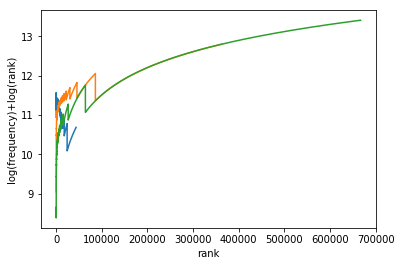

In [259]:
# Task 1
# Zif's law verification
ug.showPlot()
bg.showPlot()
tg.showPlot()

In [260]:
# Task 1
# Top 10 unigrams, bigrams, trigrams
top10Uni = dict(sorted(ug.items(), key=lambda x: x[1], reverse=True)[:10])
top10Bi = dict(sorted(bg.items(), key=lambda x: x[1], reverse=True)[:10])
top10Tri = dict(sorted(tg.items(), key=lambda x: x[1], reverse=True)[:10])

print(top10Uni)
print(top10Bi)
print(top10Tri)

{('the',): 0.07093622801935767, ('of',): 0.039303455703185775, ('and',): 0.02776098733658642, ('to',): 0.02555428353127902, ('in',): 0.02223794449813197, ('a',): 0.022168827921086463, ('is',): 0.01190564456234755, ('that',): 0.010354919906453855, ('for',): 0.00978565064460633, ('it',): 0.007604080140042752}
{('term-end', 'presentments'): 1.0, ('presentments', 'that'): 1.0, ('september-october', 'term'): 1.0, ('durwood', 'pye'): 1.0, ('pye', 'to'): 1.0, ('mayor-nominate', 'ivan'): 1.0, ('implementation', 'of'): 1.0, ('re-set', 'the'): 1.0, ('swipe', 'at'): 1.0, ('disable', 'this'): 1.0}
{('county', 'grand', 'jury'): 1.0, ('friday', 'an', 'investigation'): 1.0, ('of', "atlanta's", 'recent'): 1.0, ("atlanta's", 'recent', 'primary'): 1.0, ('recent', 'primary', 'election'): 1.0, ('election', 'produced', '``'): 1.0, ('produced', '``', 'no'): 1.0, ('any', 'irregularities', 'took'): 1.0, ('irregularities', 'took', 'place'): 1.0, ('place', '</s>', '</s>'): 1.0}


In [261]:
# Task 1
# Test cases
fd = open('test_cases.txt','r')
testcases = [sent.split() for sent in fd]

In [262]:
#Task 1
#Log likelihood
print(ug.test(testcases))
print(bg.test(testcases))
print(tg.test(testcases))

# Perplexity
print(ug.test(testcases,type='perplexity'))
print(bg.test(testcases,type='perplexity'))
print(tg.test(testcases,type='perplexity'))

[-32.83424838102342, -24.091989655768156, -23.4166871259785, -27.32603162480786, -24.734905768951318]
[-26.86317000488739, -22.339591199881653, -24.838201556634292, -inf, -21.15431998899194]
[-inf, -inf, -inf, -inf, -15.995702002744252]
[0.0014062204912880043, 0.002422397773280329, 0.0028679098737995246, 0.0010792295131443134, 0.0020627268823580876]
[0.004641888454787715, 0.003754133422712128, 0.0020101410421309316, inf, 0.005048924658664008]
[inf, inf, inf, inf, 0.01833532960709163]


In [263]:
#########  ASSIGNMENT PART 2 ###############

ug = LanguageModel(train,1,smoothing='laplace',laplace_constant=10e-4)
bg = LanguageModel(train,2,smoothing='laplace',laplace_constant=10e-4)
tg = LanguageModel(train,3,smoothing='laplace',laplace_constant=10e-4)

#Log likelihood
print(ug.test(testcases))
print(bg.test(testcases))
print(tg.test(testcases))

# Perplexity
print(ug.test(testcases,type='perplexity'))
print(bg.test(testcases,type='perplexity'))
print(tg.test(testcases,type='perplexity'))

ug = LanguageModel(train,1,smoothing='laplace',laplace_constant=10e-3)
bg = LanguageModel(train,2,smoothing='laplace',laplace_constant=10e-3)
tg = LanguageModel(train,3,smoothing='laplace',laplace_constant=10e-3)

#Log likelihood
print(ug.test(testcases))
print(bg.test(testcases))
print(tg.test(testcases))

# Perplexity
print(ug.test(testcases,type='perplexity'))
print(bg.test(testcases,type='perplexity'))
print(tg.test(testcases,type='perplexity'))

ug = LanguageModel(train,1,smoothing='laplace',laplace_constant=10e-2)
bg = LanguageModel(train,2,smoothing='laplace',laplace_constant=10e-2)
tg = LanguageModel(train,3,smoothing='laplace',laplace_constant=10e-2)

#Log likelihood
print(ug.test(testcases))
print(bg.test(testcases))
print(tg.test(testcases))

# Perplexity
print(ug.test(testcases,type='perplexity'))
print(bg.test(testcases,type='perplexity'))
print(tg.test(testcases,type='perplexity'))

ug = LanguageModel(train,1,smoothing='laplace',laplace_constant=10e-1)
bg = LanguageModel(train,2,smoothing='laplace',laplace_constant=10e-1)
tg = LanguageModel(train,3,smoothing='laplace',laplace_constant=10e-1)

#Log likelihood
print(ug.test(testcases))
print(bg.test(testcases))
print(tg.test(testcases))

# Perplexity
print(ug.test(testcases,type='perplexity'))
print(bg.test(testcases,type='perplexity'))
print(tg.test(testcases,type='perplexity'))

ug = LanguageModel(train,1,smoothing='laplace',laplace_constant=1)
bg = LanguageModel(train,2,smoothing='laplace',laplace_constant=1)
tg = LanguageModel(train,3,smoothing='laplace',laplace_constant=1)

#Log likelihood
print(ug.test(testcases))
print(bg.test(testcases))
print(tg.test(testcases))

# Perplexity
print(ug.test(testcases,type='perplexity'))
print(bg.test(testcases,type='perplexity'))
print(tg.test(testcases,type='perplexity'))

[-32.83922495016433, -24.095968248693975, -23.420675815456175, -27.32996009277662, -24.738884986977126]
[-29.91148148240914, -24.828877957598582, -26.694765968999683, -37.45723489650886, -23.797706608247186]
[-58.86889543511971, -44.853036157241974, -45.87979305449123, -50.568778716707904, -30.80051510992929]
[0.0014048215568924153, 0.0024199895374915326, 0.002865051498698575, 0.0010781701038180861, 0.0020606758926959615]
[0.002523026019432989, 0.002014831944288957, 0.0012637250985313988, 8.572991522562239e-05, 0.0026073350000850692]
[7.703936800067717e-06, 1.3494086044071024e-05, 1.0439140947445392e-05, 3.2326941081542237e-06, 0.00045276887269685796]
[-32.88379072368735, -24.13159690954856, -23.456395333476458, -27.365137775214055, -24.77451927127337]
[-35.76708006676269, -28.929970942135547, -30.736672534751047, -40.047878820858735, -28.213332294845923]
[-64.62855497682546, -50.112284205886326, -51.191795235458386, -55.930323784875725, -41.29680745160215]
[0.0013923558021514107, 0.00

In [264]:
#########  ASSIGNMENT PART 3 ###############

ug = LanguageModel(train,1,smoothing='goodturing')
bg = LanguageModel(train,2,smoothing='goodturing')
tg = LanguageModel(train,3,smoothing='goodturing')

#Log likelihood
print(ug.test(testcases))
print(bg.test(testcases))
print(tg.test(testcases))

# Perplexity
print(ug.test(testcases,type='perplexity'))
print(bg.test(testcases,type='perplexity'))
print(tg.test(testcases,type='perplexity'))


[-32.83424838102342, -24.091989655768156, -23.4166871259785, -27.32603162480786, -24.734905768951318]
[-90.18474427692236, -69.85700041672953, -72.44241553251764, -86.60365865834426, -69.75216445611312]
[-93.20092793188017, -56.28650418080523, -57.382263400490935, -62.14443733528869, 13.656538272857798]
[0.0014062204912880043, 0.002422397773280329, 0.0028679098737995246, 0.0010792295131443134, 0.0020627268823580876]
[1.4677518678682566e-08, 2.6023910050619125e-08, 1.3635299121358656e-08, 3.954824655540085e-10, 2.6714987110239893e-08]
[8.029162696228676e-09, 7.740525704374847e-07, 5.885724253388335e-07, 1.7895895951927026e-07, 30.390637020150237]


In [265]:
bg = LanguageModel(train,2,smoothing='interpolation',lambda1=0.2)
tg = LanguageModel(train,3,smoothing='interpolation')

#Log likelihood
print(bg.test(testcases))
print(tg.test(testcases))

# Perplexity
print(bg.test(testcases,type='perplexity'))
print(tg.test(testcases,type='perplexity'))

bg = LanguageModel(train,2,smoothing='interpolation',lambda1=0.5)
tg = LanguageModel(train,3,smoothing='interpolation')

#Log likelihood
print(bg.test(testcases))
print(tg.test(testcases))

# Perplexity
print(bg.test(testcases,type='perplexity'))
print(tg.test(testcases,type='perplexity'))

bg = LanguageModel(train,2,smoothing='interpolation',lambda1=0.8)
tg = LanguageModel(train,3,smoothing='interpolation')

#Log likelihood
print(bg.test(testcases))
print(tg.test(testcases))

# Perplexity
print(bg.test(testcases,type='perplexity'))
print(tg.test(testcases,type='perplexity'))

[-32.66246276441453, -26.719690688001492, -27.40283499806891, -31.35563915688864, -26.34077593024058]
[-32.5385828001288, -27.343571554618293, -27.430526465475456, -32.10895968229792, -22.62987957833191]
[0.0014553737290567707, 0.001255875083115597, 0.0010587050702298892, 0.00039409845692069074, 0.001380659517754312]
[0.0014918824606549154, 0.0010745074712685315, 0.001051401107345643, 0.0003264479889949162, 0.00349133918903733]
[-32.66246276441453, -26.719690688001492, -27.40283499806891, -31.35563915688864, -26.34077593024058]
[-32.5385828001288, -27.343571554618293, -27.430526465475456, -32.10895968229792, -22.62987957833191]
[0.0014553737290567707, 0.001255875083115597, 0.0010587050702298892, 0.00039409845692069074, 0.001380659517754312]
[0.0014918824606549154, 0.0010745074712685315, 0.001051401107345643, 0.0003264479889949162, 0.00349133918903733]
[-32.66246276441453, -26.719690688001492, -27.40283499806891, -31.35563915688864, -26.34077593024058]
[-32.5385828001288, -27.3435715546